In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
# Function for converting series data to a supervised data of format, t-1, t, t+1
## Basically feeding in the (t-1)th data to predict the t data
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [5]:
 
# load dataset
dataset = read_csv('/Users/manali/CLionProjects/exact/datasets/2020_tactic/dummy.csv')
dataset= dataset.drop(columns=["newCol","ID"])
values = dataset.values
print(dataset.head(5))
## Load Validation
validation = read_csv('/Users/manali/CLionProjects/exact/datasets/2020_tactic/dummy_validate.csv')
validation= validation.drop(columns=["newCol","ID"])
values_validation = validation.values


      Hours   Minutes   Seconds   Latency      Cost  Reliability  Friday  \
0  0.434783  0.322034  0.623683  0.014043  0.041779          1.0     0.0   
1  0.217391  0.745763  0.395252  0.001238  0.335580          1.0     0.0   
2  0.652174  0.559322  0.327957  0.002972  0.332884          1.0     0.0   
3  0.826087  0.033898  0.886267  0.001249  0.335580          1.0     0.0   
4  0.391304  0.677966  0.795115  0.040399  0.070081          1.0     0.0   

   Monday  Saturday  Sunday  ...  Server_4.0  Server_5.0  Server_6.0  \
0     0.0       0.0     0.0  ...         0.0         1.0         0.0   
1     0.0       0.0     0.0  ...         0.0         0.0         0.0   
2     0.0       1.0     0.0  ...         0.0         0.0         0.0   
3     1.0       0.0     0.0  ...         1.0         0.0         0.0   
4     0.0       0.0     0.0  ...         0.0         0.0         0.0   

   Server_7.0  Server_8.0  Tactic_1.0  Tactic_2.0  Tactic_3.0  Tactic_4.0  \
0         0.0         0.0        

In [6]:
## Calling the function to do the preprocessing the data and removing unwanted columns


# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)
reframed_validation = series_to_supervised(values_validation, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[26,27,28,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]], axis=1, inplace=True)
reframed_validation.drop(reframed_validation.columns[[26,27,28,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]], axis=1, inplace=True)
print(reframed.head(1))

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.434783   0.322034   0.623683   0.014043   0.041779        1.0   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var20(t-1)  var21(t-1)  \
1        0.0        0.0        0.0         0.0  ...         0.0         0.0   

   var22(t-1)  var23(t-1)  var24(t-1)  var25(t-1)  var26(t-1)   var4(t)  \
1         1.0         0.0         0.0         0.0         0.0  0.001238   

   var5(t)  var6(t)  
1  0.33558      1.0  

[1 rows x 29 columns]


In [7]:
## Splitting the data into training and validation sets


train = reframed.values
test = reframed_validation.values
# split into input and outputs
train_X, train_y = train[:, :-3], train[:,-3:]
test_X, test_y = test[:, :-3], test[:,-3:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(18488, 1, 26) (18488, 3) (4622, 1, 26) (4622, 3)


Train on 18488 samples, validate on 4622 samples
Epoch 1/20
18488/18488 [==============================] - 12s 642us/step - loss: 0.0184 - val_loss: 0.0094
Epoch 2/20
18488/18488 [==============================] - 11s 617us/step - loss: 0.0094 - val_loss: 0.0094
Epoch 3/20
18488/18488 [==============================] - 12s 652us/step - loss: 0.0094 - val_loss: 0.0093
Epoch 4/20
18488/18488 [==============================] - 12s 639us/step - loss: 0.0094 - val_loss: 0.0093
Epoch 5/20
18488/18488 [==============================] - 12s 625us/step - loss: 0.0093 - val_loss: 0.0093
Epoch 6/20
18488/18488 [==============================] - 11s 617us/step - loss: 0.0093 - val_loss: 0.0093
Epoch 7/20
18488/18488 [==============================] - 11s 612us/step - loss: 0.0093 - val_loss: 0.0093
Epoch 8/20
18488/18488 [==============================] - 11s 622us/step - loss: 0.0093 - val_loss: 0.0093
Epoch 9/20
18488/18488 [==============================] - 12s 626us/step - loss: 0.0093 - val_l

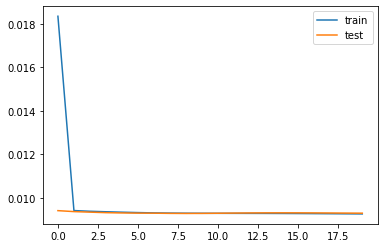

In [12]:
# design LSTM network  has 1000 hidden layers , used adam optimizer and mse loss function
model = Sequential()
model.add(LSTM(1000, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(3))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [13]:
### Doing the same process for testing dataset

test_dataset = read_csv('/Users/manali/CLionProjects/exact/datasets/2020_tactic/dummy_1.csv')
test_dataset= test_dataset.drop(columns=["newCol","ID"])
test_values = test_dataset.values
reframed_test = series_to_supervised(test_values, 1, 1)
reframed_test.drop(reframed_test.columns[[26,27,28,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]], axis=1, inplace=True)
testset = reframed_test.values
testset_X, testset_y = testset[:, :-3], testset[:,-3:]
testdataReshaped = testset_X.reshape((testset_X.shape[0], 1, testset_X.shape[1]))


In [14]:
## Feeding the test dataset for predictions
import pandas as pd

yhat = model.predict(testdataReshaped)

print(yhat)
dataset = pd.DataFrame({'predicted_Latency': yhat[:, 0], 'predicted_Cost': yhat[:, 1],
                       'predicted_Reliability': yhat[:, 2]})
dataset['predicted_Reliability'].loc[dataset['predicted_Reliability'] >0.5] = 1
dataset['predicted_Reliability'].loc[dataset['predicted_Reliability'] <0.5] = 0

[[0.02439533 0.30127624 1.012462  ]
 [0.02246236 0.29077834 1.0297976 ]
 [0.01833961 0.29151124 1.0244398 ]
 ...
 [0.02675216 0.30582917 0.9868005 ]
 [0.01656364 0.2927242  1.024493  ]
 [0.01450665 0.29986858 1.014711  ]]


In [15]:
frames = [test_dataset, dataset]
result = pd.concat(frames,axis =1)

In [16]:
import numpy as np
result.head(10)
result.to_csv('/Users/manali/JupyterProjects/predictions_LSTM.csv', sep=',', index=0)

In [17]:
print(testset_y)

[[0.00100941 0.26549865 1.        ]
 [0.00272599 0.3328841  1.        ]
 [0.00100997 0.60916442 1.        ]
 ...
 [0.00292942 0.33423181 1.        ]
 [0.00270023 0.33423181 1.        ]
 [0.00100936 0.40026954 1.        ]]


In [18]:
## Finding the root mean squared error of the model
import numpy as np

rmse = np.sqrt(mean_squared_error(yhat, testset_y))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.507
